In [16]:
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install pydot

In [17]:
from PIL import Image
from pathlib import Path
import os

data_dir = "../../hair_types"
image_extensions = [".png", ".jpg", ".jpeg", ".bmp"]


def is_valid_image_pillow(file_name):
    try:
        with Image.open(file_name) as img:
            img.verify()
            if not img.format.lower() in ['png', 'jpeg', 'bmp']:
                print(f"{file_name} is a {img.format}, not accepted by TensorFlow")
                os.remove(file_name)

    except (IOError, SyntaxError) as e:
        print(f"{file_name} is not an image")


for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        is_valid_image_pillow(filepath)
    else:
        print(f"{filepath} not in target extensions")

..\..\hair_types\Curly_Hair not in target extensions
..\..\hair_types\Straight_Hair not in target extensions
..\..\hair_types\Wavy_Hair not in target extensions


..\..\hair_types\Curly_Hair\rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif not in target extensions


In [18]:
curly_hair_pics = [label for label in Path(data_dir).rglob("Curly_Hair/*")]
straight_hair_pics = [label for label in Path(
    data_dir).rglob("Straight_Hair/*")]
wavy_hair_pics = [label for label in Path(data_dir).rglob("Wavy_Hair/*")]

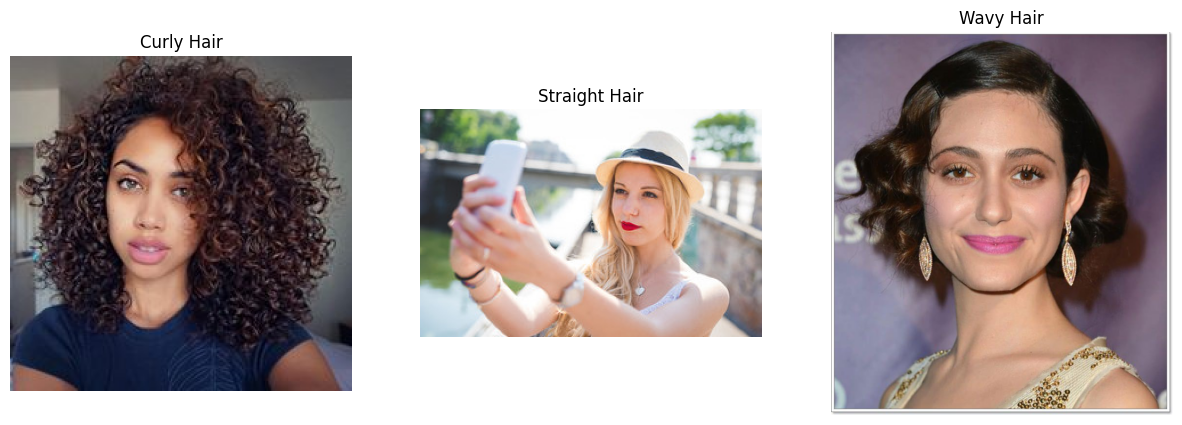

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = Image.open(str(curly_hair_pics[0]))
img2 = Image.open(str(straight_hair_pics[0]))
img3 = Image.open(str(wavy_hair_pics[0]))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Curly Hair')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Straight Hair')

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Wavy Hair')

plt.show()

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (256, 256)
batch_size = 64

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


def augment_images(image, label):
    image = data_augmentation(image)
    return image, label


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 987 files belonging to 3 classes.
Using 790 files for training.
Found 987 files belonging to 3 classes.
Using 197 files for validation.


In [21]:
hair_types_labels = [label.replace("_", " ") for label in train_ds.class_names]

In [22]:
def apply_sobel_edges(images):
    sobel_edges = tf.image.sobel_edges(images)
    sobel_edges = tf.sqrt(tf.reduce_sum(tf.square(sobel_edges), axis=-1))

    return sobel_edges


def preprocessing(image, label):
    image = apply_sobel_edges(image)

    return image, label


train_ds = train_ds.map(preprocessing)
val_ds = val_ds.map(preprocessing)

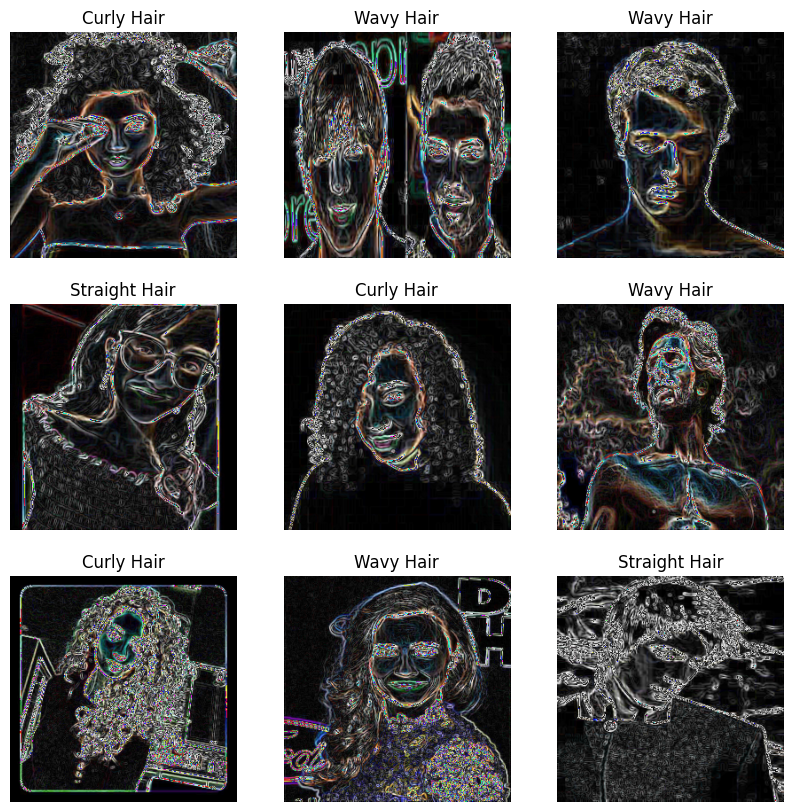

In [23]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(hair_types_labels[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [24]:

from keras.models import Sequential

model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0/255))

model.add(layers.Conv2D(filters=8, kernel_size=16,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(filters=16, kernel_size=8,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(filters=32, kernel_size=4,
          strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation('relu'))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32))
model.add(layers.Activation("relu"))

model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 121, 121, 8)    │         6,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 121, 121, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 16)     │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 57, 57, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 27, 27, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,739 (92.73 KB)

 Trainable params: 23,739 (92.73 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
epochs = 50

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
history

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2990 - loss: 1.0993 - val_accuracy: 0.2843 - val_loss: 1.0997
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3593 - loss: 1.0963 - val_accuracy: 0.2843 - val_loss: 1.1020
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3605 - loss: 1.0925 - val_accuracy: 0.2843 - val_loss: 1.1037
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3469 - loss: 1.0948 - val_accuracy: 0.2843 - val_loss: 1.1032
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3306 - loss: 1.0960 - val_accuracy: 0.2843 - val_loss: 1.1040
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3579 - loss: 1.0906 - val_accuracy: 0.2843 - val_loss: 1.1050
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3488 - loss: 1.0922 - val_accuracy: 0.2843 - val_loss: 1.1028
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3624 - loss: 1.0889 - val_accuracy: 0.2843 - val_loss:

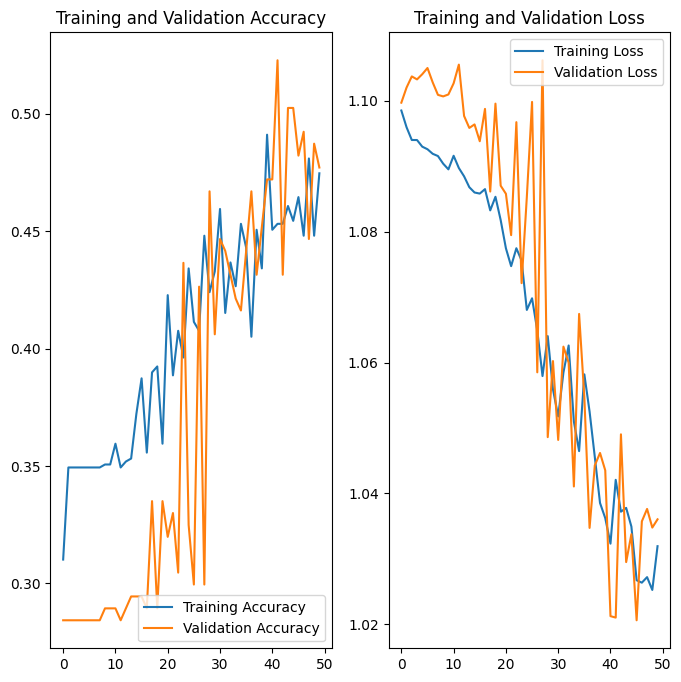

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
import numpy as np

true_labels = []
pred_labels = []

for images, labels in val_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


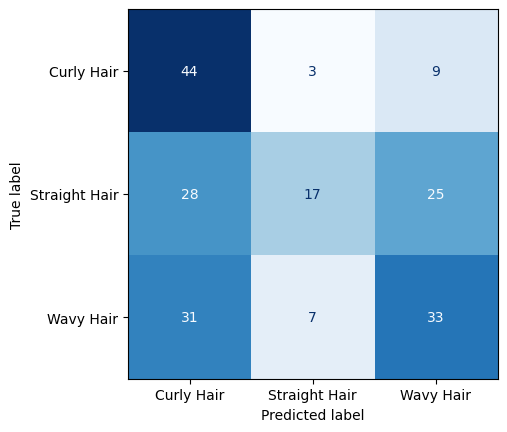

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

hair_labels_cm = ['Curly Hair', 'Straight Hair', 'Wavy Hair']

cm = confusion_matrix(true_labels, pred_labels)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hair_labels_cm).plot(
    include_values=True, cmap='Blues', colorbar=False)

In [30]:
from sklearn.metrics import classification_report
import pandas as pd

class_report = classification_report(
    true_labels, pred_labels, target_names=hair_types_labels, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

report_df = report_df.drop(index=['accuracy', 'macro avg', 'weighted avg'])
report_df = report_df.round(2)

report_df

,precision,recall,f1-score,support
Curly Hair,0.43,0.79,0.55,56.0
Straight Hair,0.63,0.24,0.35,70.0
Wavy Hair,0.49,0.46,0.48,71.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
This image is 0.91 percent curly hair, 0.03 percent straight hair, and 0.06 percent wavy hair.


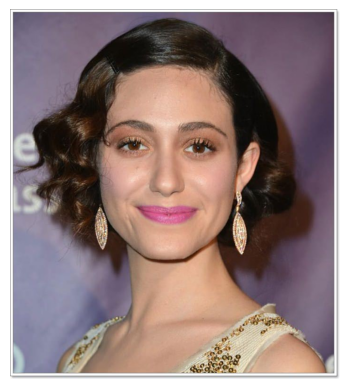

In [31]:
img_array = keras.preprocessing.image.img_to_array(img3)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

plt.axis("off")
plt.imshow(img3)